# Bibliotecas

In [35]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import math

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score

import keras.backend as K
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.layers import Dropout
from keras.utils.vis_utils import plot_model
from keras.utils.np_utils import  to_categorical
from keras.callbacks import ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier

from quickda.explore_data import explore

# Ignorar Avisos desnecessários
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

## Confere se temos GPU instalada

In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
#print(tf.config.experimental.list_physical_devices())

Num GPUs Available:  1


# Funções Auxiliares

In [10]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    f1 = history.history['get_f1']
    val_f1 = history.history['val_get_f1']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training Accuracy')
    plt.plot(x, f1, 'k', label='Training F1 Score')
    plt.plot(x, val_acc, 'r', label='Validation Accuracy')
    plt.plot(x, val_f1, 'g', label='Validation F1 Score')
    plt.title('Acurácia e F1 Score')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Perda')
    plt.legend()
    
class ModelCheckpoint_tweaked(tf.keras.callbacks.ModelCheckpoint):
    def __init__(self,
                   filepath,
                   monitor='val_loss',
                   verbose=0,
                   save_best_only=False,
                   save_weights_only=False,
                   mode='auto',
                   save_freq='epoch',
                   options=None,
                   **kwargs):
        
        #Change tf_utils source package.
        from tensorflow.python.keras.utils import tf_utils
        
        super(ModelCheckpoint_tweaked, self).__init__(filepath,
                   monitor,
                   verbose,
                   save_best_only,
                   save_weights_only,
                   mode,
                   save_freq,
                   options,
                   **kwargs)
        
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

def criar_sublistas(lista, subs):
    tam = len(lista)
    res = []
    res_df = pd.DataFrame()
    for i in range(0, tam, subs):
        tmp = lista[i:i+subs]
        if (len(tmp) == subs):
            res.append(tmp.mean())
    return res

# Análise dos Dados

## Carregando a base de dados

In [40]:
df = pd.read_csv("./data/pulsar_stars.csv", header=0, names=['MIP', 'SDIP', 'EKIP', 'SIP', 'MDM-SNR', 'SDDM-SNR', 'EKDM-SNR', 'SDM-SNR', 'target'])

In [41]:
print(f"Número de variáveis = {len(df.columns)}")

Número de variáveis = 9


## Amostra dos Dados

In [42]:
df.head()

,MIP,SDIP,EKIP,SIP,MDM-SNR,SDDM-SNR,EKDM-SNR,SDM-SNR,target
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225,0
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580,0
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909,0
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661,0
4,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306,0


## Conferindo se temos dados nulos, qual o formato das variáveis e quais podem ser numéricas ou categóricas

In [7]:
explore(df)

,dtypes,count,null_sum,null_pct,nunique,min,25%,50%,75%,max,mean,median,std,skew
MIP,float64,17898,0,0.0,8626,5.812,100.930,115.078,127.086,192.617,111.080,115.078,25.653,-1.375
SDIP,float64,17898,0,0.0,17862,24.772,42.376,46.947,51.023,98.779,46.550,46.947,6.843,0.127
EKIP,float64,17898,0,0.0,17897,-1.876,0.027,0.223,0.473,8.070,0.478,0.223,1.064,3.638
SIP,float64,17898,0,0.0,17898,-1.792,-0.189,0.199,0.928,68.102,1.770,0.199,6.168,5.181
MDM-SNR,float64,17898,0,0.0,9000,0.213,1.923,2.802,5.464,223.392,12.614,2.802,29.473,3.683
SDDM-SNR,float64,17898,0,0.0,17894,7.370,14.437,18.461,28.428,110.642,26.327,18.461,19.471,1.894
EKDM-SNR,float64,17898,0,0.0,17895,-3.139,5.782,8.434,10.703,34.540,8.304,8.434,4.506,0.442
SDM-SNR,float64,17898,0,0.0,17895,-1.977,34.961,83.065,139.309,1191.001,104.858,83.065,106.515,2.735
target,int64,17898,0,0.0,2,0.000,0.000,0.000,0.000,1.000,0.092,0.000,0.288,2.832


## Distribuição das respostas

### Abaixo verificamos que a distribuição das respostas é muito enviesada. Temos 90% de respostas 0 (não estrela de nêutrons). Vamos tratar estes dados utilizando uma técnica de reduzir esses dados para ficar compatíveis com a resposta 1 (estrela de nêutrons). Para isso vamos dividir os dados com resposta 0 em uma quantidade de grupos similar a quantidade de respostas 1, e depois iremos tirar a média dos dados desses grupos para refazer os dados com resposta 0.


In [43]:
round(df.groupby('target').count().MIP / df.shape[0] * 100, 2)

target
0    90.84
1     9.16
Name: MIP, dtype: float64

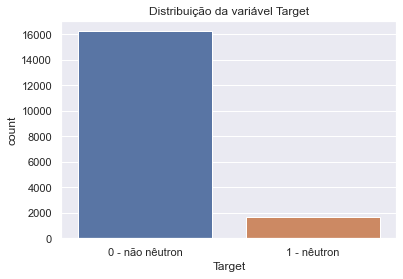

In [44]:
sns.countplot(df.target)
plt.title('Distribuição da variável Target')
plt.xlabel('Target')
plt.xticks(ticks=range(0,2), labels=['0 - não nêutron', '1 - nêutron'])
plt.show()

In [45]:
c = round(df.groupby('target').count().MIP)
print(f"Quantidades: 0 = {c[0]} e 1 = {c[1]}")
print('-'*50)
subs = math.ceil(c[0]/c[1])
negativas = df[df.target == 0]
negativas = criar_sublistas(negativas, subs)
print(negativas[0])
print(f"Quantidade final: 0 = {len(negativas)} e 1 = {c[1]}")

Quantidades: 0 = 16259 e 1 = 1639
--------------------------------------------------
MIP         112.950781
SDIP         47.918933
EKIP          0.241014
SIP           0.235100
MDM-SNR       2.308779
SDDM-SNR     16.581414
EKDM-SNR     10.721943
SDM-SNR     154.611295
target        0.000000
dtype: float64
Quantidade final: 0 = 1625 e 1 = 1639


In [46]:
df_tst = pd.DataFrame()
df_tst = pd.concat(negativas, ignore_index=True, axis=1).T
df_tst

,MIP,SDIP,EKIP,SIP,MDM-SNR,SDDM-SNR,EKDM-SNR,SDM-SNR,target
0,112.950781,47.918933,0.241014,0.235100,2.308779,16.581414,10.721943,154.611295,0.0
1,122.826562,49.221999,0.077544,0.017286,4.718562,24.909668,7.806080,81.871273,0.0
2,112.427344,49.117316,0.202946,0.058117,3.173913,19.209042,9.373305,111.543404,0.0
3,121.482812,46.729040,0.098601,0.324605,2.380853,16.975910,10.749121,154.253410,0.0
4,116.225781,48.677019,0.226620,0.109116,2.432358,17.298481,10.144861,127.757623,0.0
...,...,...,...,...,...,...,...,...,...
1620,111.690625,46.934039,0.215711,0.321320,16.111789,34.533356,7.078829,78.093823,0.0
1621,117.635156,49.079374,0.234606,0.107255,4.347492,22.373660,8.792710,98.365991,0.0
1622,114.566406,43.731026,0.276497,1.037177,2.783863,18.012064,11.382899,171.067199,0.0
1623,116.150000,47.684957,0.212700,0.291412,3.907023,20.858949,9.947946,137.493596,0.0


In [47]:
positivas = df[df.target == 1]
df_final = pd.concat([df_tst, positivas])
df_final

,MIP,SDIP,EKIP,SIP,MDM-SNR,SDDM-SNR,EKDM-SNR,SDM-SNR,target
0,112.950781,47.918933,0.241014,0.235100,2.308779,16.581414,10.721943,154.611295,0.0
1,122.826562,49.221999,0.077544,0.017286,4.718562,24.909668,7.806080,81.871273,0.0
2,112.427344,49.117316,0.202946,0.058117,3.173913,19.209042,9.373305,111.543404,0.0
3,121.482812,46.729040,0.098601,0.324605,2.380853,16.975910,10.749121,154.253410,0.0
4,116.225781,48.677019,0.226620,0.109116,2.432358,17.298481,10.144861,127.757623,0.0
...,...,...,...,...,...,...,...,...,...
17515,89.867188,47.482295,1.591325,2.505057,0.763378,12.393561,17.940745,333.902630,1.0
17529,27.039062,33.754722,4.779124,26.255357,129.863712,78.815440,-0.348492,-0.893791,1.0
17558,77.070312,39.000638,1.884421,6.372178,38.517559,65.741059,1.589513,1.285346,1.0
17642,28.375000,27.649311,6.377273,45.944048,141.860368,82.893017,-0.477222,-1.067880,1.0


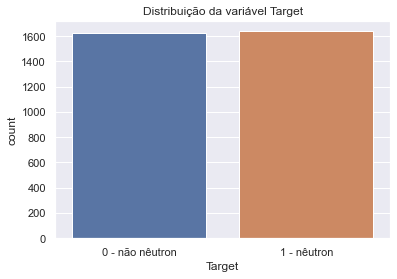

In [48]:
sns.countplot(df_final.target)
plt.title('Distribuição da variável Target')
plt.xlabel('Target')
plt.xticks(ticks=range(0,2), labels=['0 - não nêutron', '1 - nêutron'])
plt.show()

## Análise de correlação

### Todas as variáveis estão correlacionadas. Fica difícil decidir qual retirar.

In [49]:
corr = df_final.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,MIP,SDIP,EKIP,SIP,MDM-SNR,SDDM-SNR,EKDM-SNR,SDM-SNR,target
MIP,1.00,0.74,-0.96,-0.87,-0.68,-0.75,0.80,0.69,-0.81
SDIP,0.74,1.00,-0.81,-0.82,-0.33,-0.49,0.53,0.50,-0.59
EKIP,-0.96,-0.81,1.00,0.97,0.66,0.73,-0.76,-0.66,0.74
SIP,-0.87,-0.82,0.97,1.00,0.60,0.62,-0.66,-0.56,0.61
MDM-SNR,-0.68,-0.33,0.66,0.60,1.00,0.79,-0.77,-0.58,0.53
SDDM-SNR,-0.75,-0.49,0.73,0.62,0.79,1.00,-0.93,-0.80,0.74
EKDM-SNR,0.80,0.53,-0.76,-0.66,-0.77,-0.93,1.00,0.94,-0.77
SDM-SNR,0.69,0.50,-0.66,-0.56,-0.58,-0.80,0.94,1.00,-0.72
target,-0.81,-0.59,0.74,0.61,0.53,0.74,-0.77,-0.72,1.00


In [50]:
X = df_final.iloc[:,0:8].to_numpy()
X[:10]

array([[ 1.12950781e+02,  4.79189331e+01,  2.41013884e-01,
         2.35099994e-01,  2.30877926e+00,  1.65814140e+01,
         1.07219431e+01,  1.54611295e+02],
       [ 1.22826562e+02,  4.92219992e+01,  7.75444434e-02,
         1.72862243e-02,  4.71856187e+00,  2.49096679e+01,
         7.80608041e+00,  8.18712730e+01],
       [ 1.12427344e+02,  4.91173165e+01,  2.02946384e-01,
         5.81168050e-02,  3.17391304e+00,  1.92090420e+01,
         9.37330479e+00,  1.11543404e+02],
       [ 1.21482812e+02,  4.67290396e+01,  9.86012275e-02,
         3.24605424e-01,  2.38085284e+00,  1.69759095e+01,
         1.07491208e+01,  1.54253410e+02],
       [ 1.16225781e+02,  4.86770186e+01,  2.26619949e-01,
         1.09115748e-01,  2.43235786e+00,  1.72984810e+01,
         1.01448609e+01,  1.27757623e+02],
       [ 1.18429688e+02,  4.89921795e+01,  2.32732414e-01,
         2.45563827e-01,  3.99489967e+00,  1.91570600e+01,
         1.09159718e+01,  1.72104672e+02],
       [ 1.19391406e+02,  5.000659

In [51]:
y = df_final.target.to_numpy()
y[:10]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

## Padronizando os dados com o StandardScaler do SKlearn. 
### Dados finais com média 0 e variância igual ao desvio padrão

In [52]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
print(X[:5])

[[ 0.716266    0.67376385 -0.72724048 -0.62183544 -0.70017257 -1.04401482
   1.2475344   1.35014504]
 [ 0.98368118  0.85240386 -0.81003907 -0.63927886 -0.63795524 -0.67191491
   0.50902702  0.24756328]
 [ 0.70209243  0.83805269 -0.74652198 -0.63600898 -0.67783599 -0.92661444
   0.90596161  0.69732875]
 [ 0.94729528  0.51063891 -0.79937364 -0.61466747 -0.69831173 -1.02638906
   1.25441777  1.34472028]
 [ 0.80494604  0.77769135 -0.73453113 -0.63192477 -0.69698194 -1.01197682
   1.10137544  0.94310133]]


In [53]:
num_features = X.shape[1]
X.shape

(3264, 8)

In [54]:
y.shape

(3264,)

### Dividindo a Base de Dados entre Treino e Teste, com 20% para os testes.

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [56]:
X_train.shape

(2611, 8)

In [57]:
y_train.shape

(2611,)

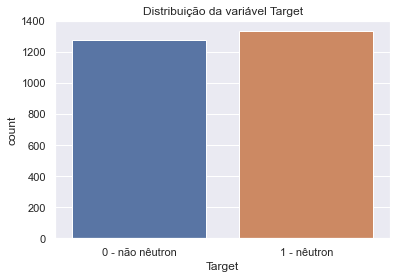

In [58]:
sns.countplot(y_train)
plt.title('Distribuição da variável Target')
plt.xlabel('Target')
plt.xticks(ticks=range(0,2), labels=['0 - não nêutron', '1 - nêutron'])
plt.show()

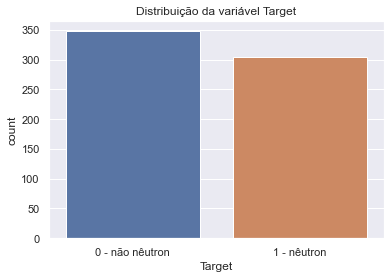

In [59]:
sns.countplot(y_test)
plt.title('Distribuição da variável Target')
plt.xlabel('Target')
plt.xticks(ticks=range(0,2), labels=['0 - não nêutron', '1 - nêutron'])
plt.show()

# Modelo de MLP

## Criando o modelo

In [89]:
model = Sequential()
model.add(Dense(8, input_dim=num_features, activation='relu'))
#model.add(Dropout(0.1))
#model.add(Dense(7, activation='relu'))
#model.add(Dense(3, activation='relu'))
#model.add(Dropout(0.2))
model.add(Dense(1 , activation='sigmoid'))
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 9         
Total params: 81
Trainable params: 81
Non-trainable params: 0
_________________________________________________________________
None


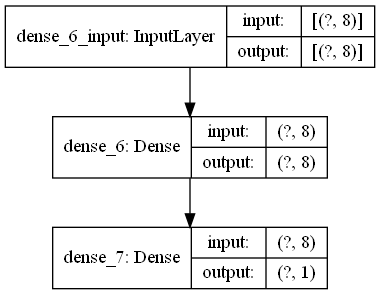

In [81]:
plot_model(model, show_shapes=True, show_layer_names=True)

## Compilando e treinando o modelo. 
### Vamos utilizar a função de Callback ModelCheckPointer para salvar o modelo com a melhor accuracia na base de validação (que é a mesma de teste final pois temos uma base muito pequena)

In [90]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', get_f1])

In [91]:
%%time
checkpointer = ModelCheckpoint_tweaked(filepath='./modelo_mlp_ex3_3.hdf5', verbose=1,  mode='max', save_best_only=True, monitor='val_get_f1')

#history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=16, verbose=1, callbacks=[checkpointer])
history = model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=64, verbose=1, callbacks=[checkpointer])

Epoch 1/100
19/33 [================>.............] - ETA: 0s - loss: 0.7133 - accuracy: 0.6143 - get_f1: 0.3937
Epoch 00001: val_get_f1 improved from -inf to 0.64685, saving model to .\modelo_mlp_ex3_3.hdf5
33/33 [==============================] - 0s 10ms/step - loss: 0.6695 - accuracy: 0.6561 - get_f1: 0.4798 - val_loss: 0.5827 - val_accuracy: 0.7247 - val_get_f1: 0.6468
Epoch 2/100
25/33 [=====================>........] - ETA: 0s - loss: 0.5414 - accuracy: 0.7825 - get_f1: 0.7233
Epoch 00002: val_get_f1 improved from 0.64685 to 0.81307, saving model to .\modelo_mlp_ex3_3.hdf5
33/33 [==============================] - 0s 3ms/step - loss: 0.5263 - accuracy: 0.7979 - get_f1: 0.7474 - val_loss: 0.4678 - val_accuracy: 0.8470 - val_get_f1: 0.8131
Epoch 3/100
24/33 [====================>.........] - ETA: 0s - loss: 0.4340 - accuracy: 0.8607 - get_f1: 0.8390
Epoch 00003: val_get_f1 improved from 0.81307 to 0.84718, saving model to .\modelo_mlp_ex3_3.hdf5
33/33 [==============================]

## Gráfico comparativo da Acurácia , F1 Score e Perda no treinamento

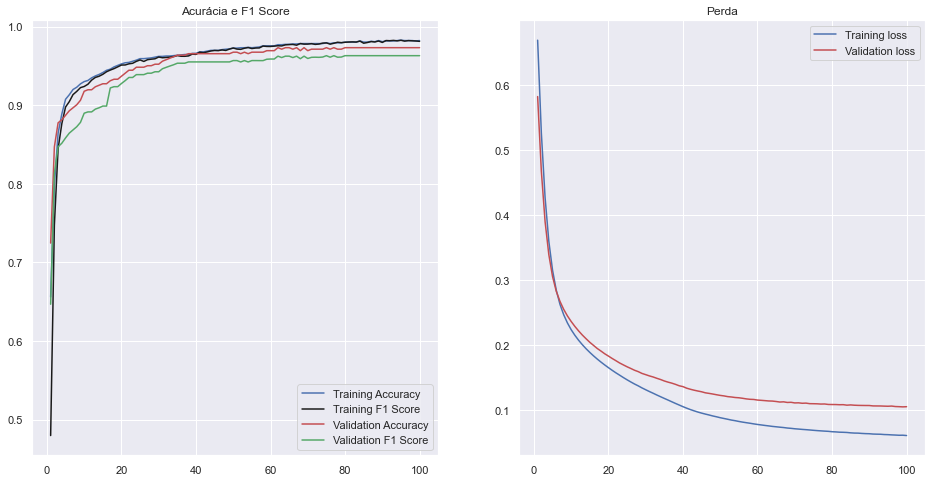

In [92]:
plot_history(history)

## Apresentando a Acurácia e F1 Score final do Treino, carregando o melhor modelo salvo e apresentando a Acurácia e F1 Score do Teste

In [93]:
scores = model.evaluate(X_train, y_train)
print()
print(f"Acurácia do Treino: {round(scores[1]*100,2)}%")
print(f"F1 Score do Treino: {round(scores[2]*100,2)}%")

82/82 [==============================] - 0s 2ms/step - loss: 0.0699 - accuracy: 0.9809 - get_f1: 0.9800

Acurácia do Treino: 98.09%
F1 Score do Treino: 98.0%


In [94]:
model = load_model("./modelo_mlp_ex3_3.hdf5", custom_objects={'get_f1': get_f1})

In [95]:
scores = model.evaluate(X_test, y_test)
print()
print(f"Acurácia do Teste: {round(scores[1]*100,2)}%")
print(f"F1 Score do Teste: {round(scores[2]*100,2)}%")

21/21 [==============================] - 0s 2ms/step - loss: 0.0812 - accuracy: 0.9755 - get_f1: 0.9744

Acurácia do Teste: 97.55%
F1 Score do Teste: 97.44%


## Conseguimos uma Acurácia final maior que 95% com uma rede muito simples. Utilizamos a métrica F1 Score para analisar e verificar o melhor modelo, pois a acurácia não nos permitia ver o vies que era introduzido pela diferença de valores da variável resposta (Target).